# Single item characterisation plots

Collection of random plots for chapter 4.

* Fisher Information stuff is in: [../fisherinfo_new_2016/notebook_fisher_fits_2016.ipynb](../fisherinfo_new_2016/notebook_fisher_fits_2016.ipynb)
* Fisher Information, 2d plots are in: [../fisherinfo_new_2016/notebook_fisher_random_large_2try_310816.ipynb](../fisherinfo_new_2016/notebook_fisher_random_large_2try_310816.ipynb)



In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data

import re
import inspect
import imp

import utils
import load_experimental_data
import highdimensionnetwork
import hierarchicalrandomnetwork

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

## Hierarchical network

In [4]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='sample',
    N=100,
    num_samples=50,
    label='thesis_hierarchical_coverage',
    output_directory='./Figures/thesis/hierarchical_coveragespace/',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    M=100,
    code_type='hierarchical',
    type_layer_one='feature',
    output_both_layers=None,
    ratio_hierarchical=0.3,
    normalise_weights=1,
    threshold=1.0,
    sigmax=0.3,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,    
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network
    
sampler.fit_mixture_model()

{'K': 0.0,
 'aic': 284.68733540806255,
 'bic': 292.50284596602683,
 'kappa': 55.886660902059916,
 'mixt_nontargets': 0.0,
 'mixt_nontargets_sum': 0.0,
 'mixt_random': 0.61359968489875416,
 'mixt_target': 0.38640031510124573,
 'train_LL': -139.34366770403128}

In [256]:
dataio = DataIO(label='hierarchical_network', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Figures/thesis/single_item_characterisation/hierarchical_network-6b295e07-6833-4ef5-a831-f098b0645868 ===


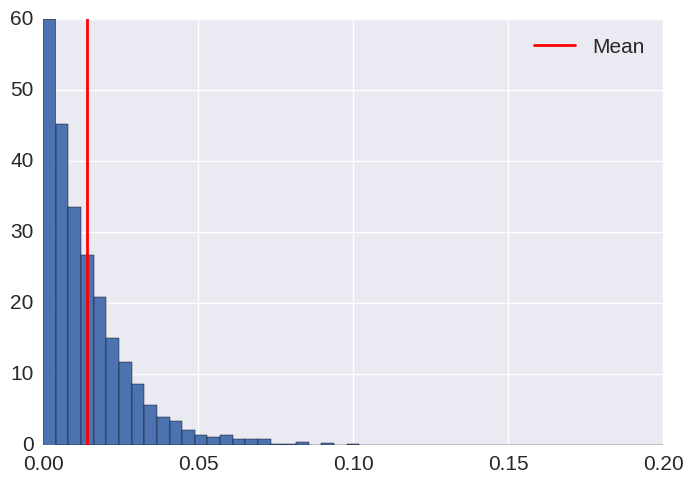

In [258]:
f, ax = plt.subplots()
ax.hist(network.A_sampling.flatten(), bins=np.linspace(0, 0.2, 50), normed=True)
ax.axvline(np.mean(network.A_sampling), color='r')
ax.legend(['Mean'])

# f.savefig(dataio.create_formatted_filename("hist_weights_{label}_{unique_id}.pdf"))

In [272]:
ratio_space = np.linspace(0., 0.9, 50)
num_repetitions = 1

mem_fidelities = np.zeros((ratio_space.size, num_repetitions))
precisions = np.zeros((ratio_space.size, num_repetitions))

for ratio_i, ratio in progress.ProgressDisplay(enumerate(ratio_space), display=progress.SINGLE_LINE):
#     print "Ratio hierarchical:", ratio
    arguments_dict['ratio_hierarchical'] = ratio
    
    for repet_i in xrange(num_repetitions):
        with io.capture_output(display=False, stdout=True) as captured:
            experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
            sampler = experiment_launcher.all_vars['sampler']

            mem_fidelities[ratio_i, repet_i] = sampler.fit_mixture_model()['kappa']
            precisions[ratio_i, repet_i] = sampler.get_precision()


[100%] 13m14s                                                                 


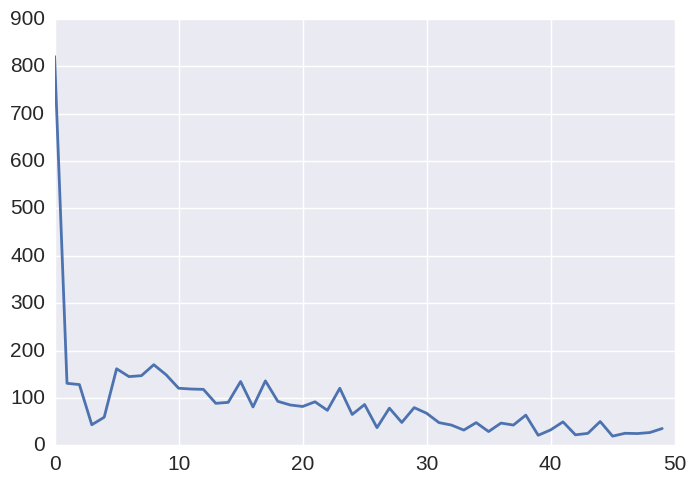

In [269]:
plt.plot(ratio_space, mem_fidelities)

### 2D plot of M and ratio

In [ ]:
%cd /nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels/

with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fit_mixturemodels_hierarchical_sigmaxMratio_random_270617.py

/nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels


In [467]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]
def std_lastaxis(array_name, array):
    return [('std_' + array_name, utils.nanstd(array, axis=-1))]


def process_precision(array_name, array):
    outputs = avg_lastaxis(array_name, array)
    outputs.extend(std_lastaxis(array_name, array))
    outputs.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs
    
def process_fi(array_name, array):
    outputs = avg_twice_lastaxis(array_name, array)
    outputs.extend(avg_twice_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs

def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    outputs_all = avg_lastaxis(array_name, array)
    
    if array_name.find('inv') > -1:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2.*array)**0.5))
    else:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    
    outputs = [(o[0], o[1][:, 0]) for o in outputs_all]
    return outputs

def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'
                                            ])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    outputs.append((array_name + '_stddev', utils.kappa_to_stddev(emfits_all[:, 0])))
    
    return outputs

    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [468]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

In [469]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

In [471]:
pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=process_precision)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

M_space = np.sort(df_all_fits['M'].unique())
ratio_hier_space = np.sort(df_all_fits['ratio_hierarchical'].unique())
sigmax_space = np.sort(df_all_fits['sigmax'].unique())


IndexError: index 1 is out of bounds for axis 1 with size 1

In [429]:
result_em_fits = utils.nanmean(data_pbs.dict_arrays['result_em_fits']['results_flat'], axis=-1).squeeze()
result_fidelity = result_em_fits[..., 0]
result_all_precisions = utils.nanmean(data_pbs.dict_arrays['result_all_precisions']['results_flat'], axis=-1).squeeze()
parameters = np.array(data_pbs.dict_arrays['result_em_fits']['parameters_flat'])
parameters_order = data_pbs.dataset_infos['parameters']

print(parameters.size)

9762


In [452]:
# Mask sigmax == 0.2
filter_mask = (parameters[:, 2] - 0.3)**2. < 0.001
# filter_mask &= result_fidelity < np.percentile(result_fidelity, 98)
filter_mask &= np.abs(spst.zscore(result_fidelity)) < 5


parameters_filtered = parameters[filter_mask]
precisions_filtered = result_all_precisions[filter_mask]
fidelity_filtered = result_fidelity[filter_mask]

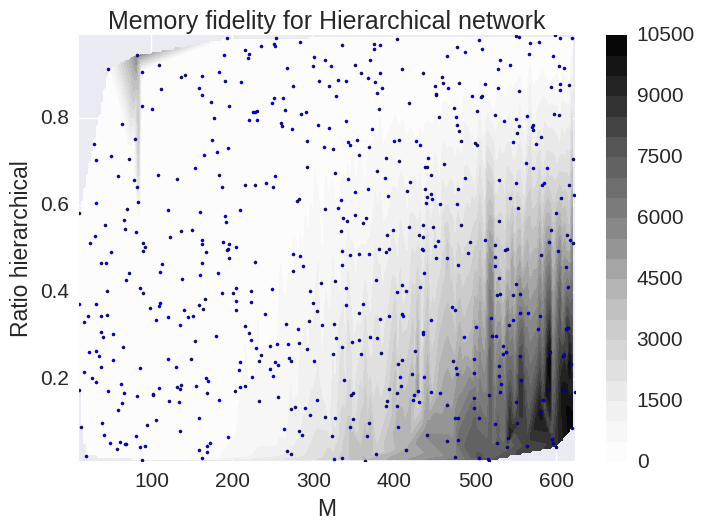

In [453]:
utils.contourf_interpolate_data(parameters_filtered[:, [0, 1]], 
                                fidelity_filtered, 
                                xlabel='M', ylabel='Ratio hierarchical', 
                                title='Memory fidelity for Hierarchical network', 
                                interpolation_numpoints=200, 
                                interpolation_method='linear',
                               )

In [445]:
parameters[0,0]*parameters[0, 1]

277.479421954722